# Tasks

Based on the task description provided, here's a structured step-by-step plan to complete your sentiment analysis mini-challenge. Each step is tailored to ensure compatibility with the challenge requirements and provided data.

---

### **Step 1: Setup and Dataset Selection**
1. **Select Dataset**:
   - Use one of the recommended datasets such as `sst2`, `amazon_polarity`, or `financial_phrasebank`.
   - Download the dataset using Hugging Face's `datasets` library.

2. **Environment Setup**:
   - Install required libraries: `transformers`, `datasets`, `scikit-learn`, `matplotlib`, `seaborn`, and `pandas`.
   - Set up `requirements.txt` or `environment.yml` file for reproducibility.

---

### **Step 2: Data Exploration and Preprocessing**
1. **Explore Dataset**:
   - Check for class distribution and balance (positive, negative, neutral).
   - Basic statistical analysis (e.g., sentence length, vocabulary size).

2. **Preprocess Data**:
   - Tokenize texts using a Hugging Face tokenizer.
   - Create nested data splits for different training set sizes.

---

### **Step 3: Baseline Model**
1. **Model Selection**:
   - Choose a pre-trained transformer model (e.g., `bert-base-uncased`) for sentiment classification.

2. **Training**:
   - Fine-tune the model on the hierarchical datasets.
   - Use a validation set or cross-validation for performance evaluation.
   - Record performance metrics (accuracy, F1 score).

---

### **Step 4: Text Embeddings and Weak Labeling**
1. **Generate Embeddings**:
   - Use a sentence-transformer model to create embeddings for all texts.
   - Explore embedding similarities visually (e.g., using t-SNE or UMAP).

2. **Weak Labeling**:
   - Implement algorithms to assign labels based on embedding similarities.
   - Evaluate the quality of weak labels (e.g., agreement with ground truth).

---

### **Step 5: Enhanced Model Training**
1. **Combine Labels**:
   - Integrate weak labels with manual labels for training.
   - Use all weak labels where manual labels are unavailable.

2. **Training**:
   - Train the model using both hard and weak labels.
   - Evaluate and compare performance against the baseline.

---

### **Step 6: Performance Analysis**
1. **Learning Curve**:
   - Plot model performance vs. training data size.
   - Analyze improvements from weak labels.

2. **Comparison**:
   - Compare results of baseline and weakly labeled models.
   - Analyze the trade-off between annotation cost and performance.

---

### **Step 7: Reporting**
1. **Documentation**:
   - Create well-commented and structured notebooks.
   - Save a rendered `.html` or `.pdf` version of the analysis.

2. **Repository**:
   - Prepare a clean, documented repository including all code and dependencies.

3. **Discussion of AI Usage**:
   - Document how tools like ChatGPT assisted in the project, with examples.

---

Would you like me to begin implementing this step-by-step solution, starting with the environment setup and dataset loading?

# 1. Setup and Data Selection

**Dataset**

[The Stanford Sentiment Treebank](https://huggingface.co/datasets/stanfordnlp/sst2) is a corpus with fully labeled parse trees that allows for a complete analysis of the compositional effects of sentiment in language. The corpus is based on the dataset introduced by Pang and Lee (2005) and consists of 11'855 single sentences extracted from movie reviews. It was parsed with the Stanford parser and includes a total of 215'154 unique phrases from those parse trees, each annotated by 3 human judges.

Binary classification experiments on full sentences (negative or somewhat negative vs somewhat positive or positive with neutral sentences discarded) refer to the dataset as SST-2 or SST binary.

In [1]:
import os
import sys
import pandas as pd
from transformers import BertTokenizer

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from pipeline_utils import *
from weak_labelling import *

device = get_device()

Using MPS (Metal Performance Shaders)
Selected device: mps


In our previous notebook `eda_preprocessing.ipynb` we have already explored the dataset, preprocessed it and created nested data splits for different training set sizes. We will now proceed with the next steps.

In [2]:
# load nested train splits (all files in /data/nested_splits)
nested_splits = {}
splits_dir = "../data/nested_splits"
split_sizes = ["1%", "10%", "30%", "50%", "75%", "100%"]
nested_splits = {size: pd.read_csv(f"{splits_dir}/train_split_{size}.csv") for size in split_sizes}

df_train = pd.read_csv("../data/train.csv")
df_val = pd.read_csv("../data/val.csv")
df_test = pd.read_csv("../data/test.csv")

Now that we have our data loaded we can continue with creating our baseline model.

## Baseline Model

In this task, we utilize **Fine-Tuning**, where all layers of a pre-trained model (`bert-base-uncased`) are retrained to adapt to the sentiment classification task. This approach is suitable given the availability of hierarchical data splits ranging from 1% to 100% and the need to incorporate weak labels effectively. Fine-tuning allows us to fully leverage the model's pre-trained knowledge while adapting it to our task-specific dataset.

We evaluate the model's performance across different training data sizes, identifying suitable hyperparameters to optimize performance. A reusable training pipeline is built to streamline experimentation and enable scaling to computation clusters for more intensive tasks. Post-training quantization can be applied to reduce memory consumption without sacrificing model performance.

In [45]:
# Initialize Tokenizer and tokenize validation set
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
validation_ds = convert_and_tokenize(df_val, tokenizer)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

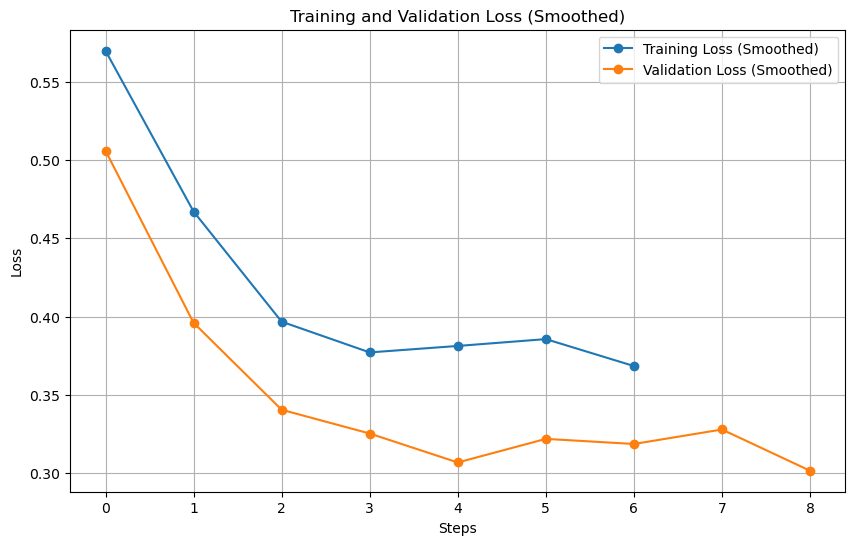

Early stopping triggered after 2 evaluations.


In [9]:
metrics = []
for size, train_df in nested_splits.items():
    print(f"Training with {size} of data...")
    train_ds = convert_and_tokenize(train_df, tokenizer)

    # Calculate total training steps for the callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collecft metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics.append(split_metrics)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("../data/baseline_metrics.csv", index=False)

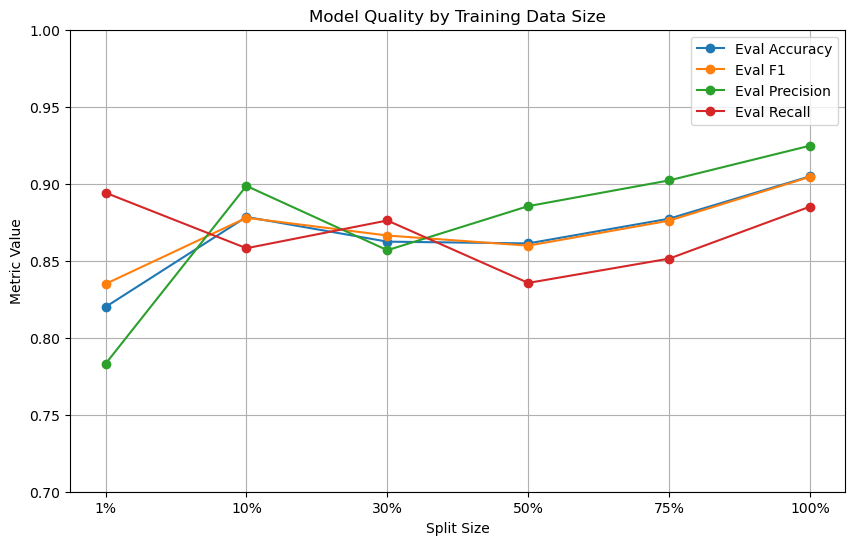

In [17]:
# plot_metrics(metrics_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

The plot shows how evaluation metrics (accuracy, F1, precision, and recall) evolve as the training dataset size increases:

1. **1% Split**:
   - Metrics are relatively lower due to limited data for learning meaningful patterns.
   - Recall is the highest, indicating the model is identifying more true positives but at the expense of some false positives

2. **10% Split**:
   - Significant improvement in precision accuracy and F1 score.
   - The model benefits from the increased training data, achieving better balance between precision and recall.

3. **30% Split**:
   - Dip in precision while other metrics remain pretty steady. This could indicate slight overfitting or under-optimization in this split.

4. **50% to 100% Splits**:
   - Metrics consistently improve with more data.
   - Recall, precision, F1 score and accuracy stabilize, with recall showing the most significant gains as the model learns to generalize better.

**General Observations**:
- Adding more data helps the model learn more robust patterns, leading to steady improvements across all metrics.
- Precision, accuracy and F1 score clearly trend upward, indicating a good balance in classification performance.
- Why is recall so high with 1% data split?
- The gap between metrics narrows with larger splits, suggesting better overall generalization.

## Text Embeddings

To represent texts numerically, we use **sentence embeddings** generated by the `all-MiniLM-L6-v2` model from the Sentence-Transformers library. These embeddings capture the semantic meaning of entire sentences as high-dimensional vectors, enabling us to quantify similarities between texts. By focusing on the validation and test sets, we ensure an unbiased evaluation of how well embeddings generalize to unseen data.

To assess embedding quality, we calculate **cosine similarity**, which measures the semantic closeness between vectors. For example, we use a reference sentence ("it 's slow -- very , very slow .") and calculate its similarity with other sentences in the dataset. The top-5 most similar sentences are retrieved, showcasing the model's ability to group semantically related content.

This process helps us understand how well embeddings capture sentence meaning, which is crucial for downstream tasks like weak labeling and retrieval.

In [12]:
# Define labeled datasets from train and validation sets
labeled_sentences = df_val["sentence"].tolist()     # Validation set sentences
labeled_labels = df_val["label"].tolist()           # Validation set labels

# Generate embeddings with specifies model
model_name = "all-MiniLM-L6-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

### Samples of most similar sentences

In this section we want to showcase the most similar sentences to a given reference sentence. This helps us understand how well the embeddings capture sentence meaning and semantic relationships.

In [13]:
reference_index = 4
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: it 's slow -- very , very slow . 
Similarity: 0.5328, Sentence: too slow , too long and too little happens . 
Similarity: 0.4427, Sentence: it moves quickly , adroitly , and without fuss ; it does n't give you time to reflect on the inanity -- and the cold war datedness -- of its premise . 
Similarity: 0.3994, Sentence: a fast , funny , highly enjoyable movie . 
Similarity: 0.3646, Sentence: the longer the movie goes , the worse it gets , but it 's actually pretty good in the first few minutes . 


**Observations**:
- The most similar sentences to the reference sentence `it 's slow -- very , very slow ` share thematic elements like "slow", "boring", "too long" and more negative sentiments. 

In [14]:
reference_index = 300
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: fun , flip and terribly hip bit of cinematic entertainment . 
Similarity: 0.5961, Sentence: enormously entertaining for moviegoers of any age . 
Similarity: 0.5919, Sentence: the film 's performances are thrilling . 
Similarity: 0.5815, Sentence: passable entertainment , but it 's the kind of motion picture that wo n't make much of a splash when it 's released , and will not be remembered long afterwards . 
Similarity: 0.5602, Sentence: unfortunately , it 's not silly fun unless you enjoy really bad movies . 


**Observations**:

- The most similar sentences share thematic elements like "entertaining", "fun" and more positive sentiments.

In Conclusion, we can say the embeddings are capturing semantic similarities pretty well.

### Furthest and Closest Sentences

In [17]:
get_min_max_distance(embeddings, labeled_sentences)

Sentence with the furthest distance to any other sentence:
'if you believe any of this , i can make you a real deal on leftover enron stock that will double in value a week from friday . '

Sentence closest to the most others (minimum average distance):
'a pleasant enough romance with intellectual underpinnings , the kind of movie that entertains even as it turns maddeningly predictable . '


Here we can see the sentences that are the closest and furthest from the other sentence embeddings from the validation set.

### Visualizing Embeddings

In this section we will examine the embeddings of the validation set using the dimensionality reduction techniques (t-SNE and UMAP) to visualize high-dimensional data in 2D space. These visualizations could help us understand the distribution of embeddings and identify clusters or patterns that may inform downstream tasks.

Reducing dimensionality with TSNE...


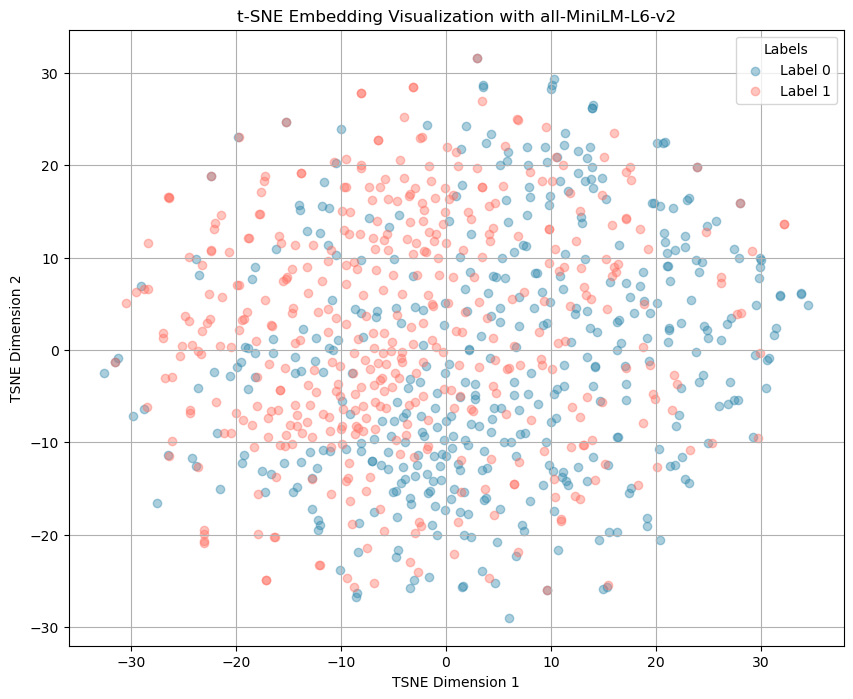

In [15]:
# Using t-SNE
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="tsne"
)

The t-SNE embedding visualization demonstrates overlapping clusters for labels `0`, and `1`, indicating that the embedding space does not perfectly separate the classes.

Reducing dimensionality with UMAP...


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


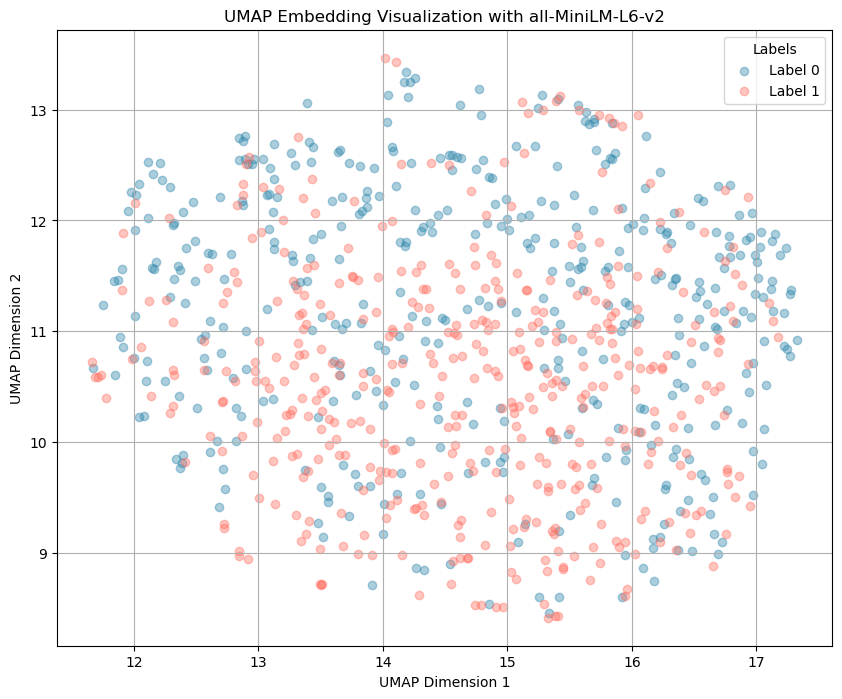

In [16]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"UMAP Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows that the classes (`Label 0` and `Label 1`) are largely overlapping in the reduced 2D space, similar to the t-SNE method.

In conclusion, these overlaps could be due to the complexity of the sentiment classification task, or more probable the limitations and simplicity of the embedding model. Further steps could include changing the embedding model to achieve better separability.


### Different Embedding Model

Since the current embeddings do not perfectly separate the classes, we can try using a different embedding model. Based on the website [sbert.com](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) we will use the `all-mpnet-base-v2` model to generate embeddings and visualize them using t-SNE and UMAP and see if the separability of classes improves.

In [18]:
model_name = "all-mpnet-base-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Reducing dimensionality with TSNE...


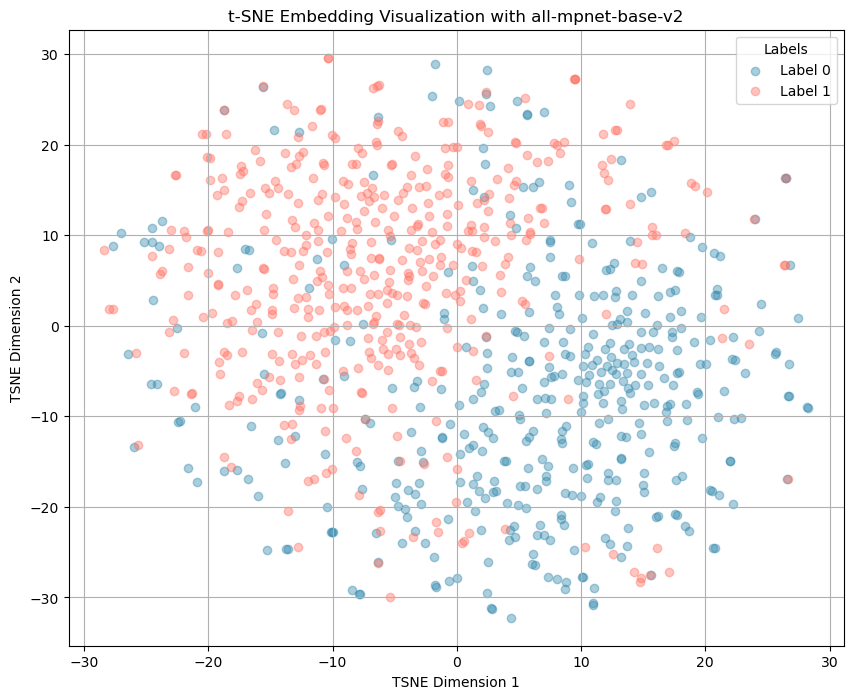

In [19]:
# Using t-SNE
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="tsne"
)

The t-SNE visualization using the `all-mpnet-base-v2` model shows better clustering compared to the previous model. We can clearly see some grouping patterns. However, there is still some overlap between the two classes, indicating challenges in complete separation of semantic representations for different labels.

Reducing dimensionality with UMAP...


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


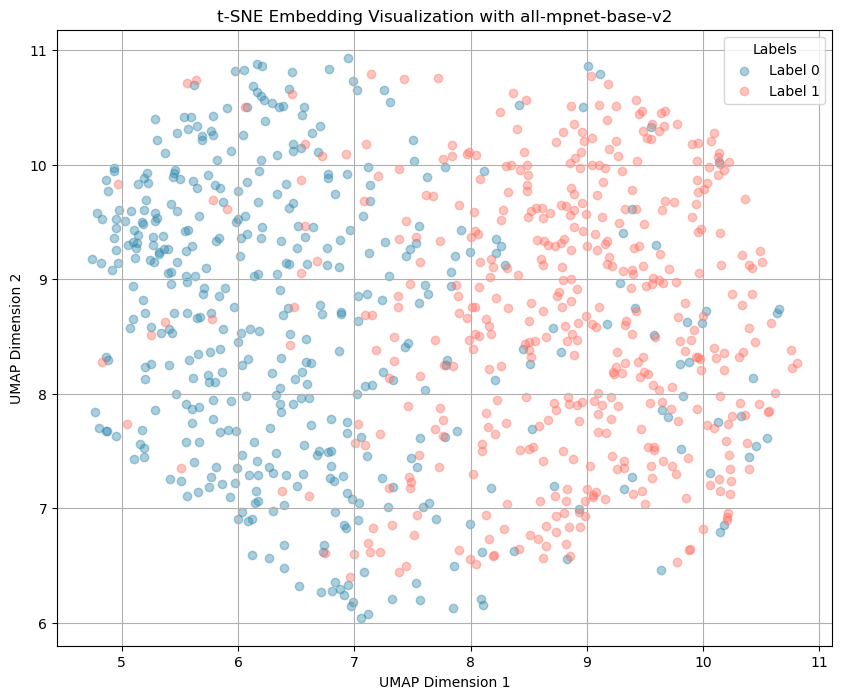

In [20]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows similar results to the t-SNE method.

In conclusion, the `all-mpnet-base-v2` model provides better separability between classes compared to the previous model and we can consider using it for downstream tasks.

## Weak Labeling

Weak labeling assigns pseudo-labels to unlabeled data by leveraging embedding-based similarities and predefined techniques. The goal is to create meaningful labels for unlabeled datasets, enabling their use in downstream tasks such as training or evaluation. 

- **Validation Set**: The labeled validation set serves as a benchmark for evaluating weak labeling techniques. By comparing the weak labels generated for the validation set with its ground truth labels, we identify the most effective technique.

- **Test Set**: The test set is fully unlabeled (`-1` labels), so weak labeling is applied after selecting the best technique. The generated weak labels make this dataset usable for subsequent tasks, but no direct evaluation against ground truth is possible since the test set lacks true labels.

---

**Techniques for Weak Labeling**

1. **Majority Vote**: Assigns the most frequent label among the top-k most similar labeled sentences based on cosine similarity.

2. **Weighted Voting**: Weights the labels of top-k similar sentences by their similarity scores, assigning the label with the highest cumulative weight.

3. **Centroid-Based Labeling**: Precomputes centroids for each class in the labeled embedding space and assigns the label of the closest centroid to each unlabeled sentence.

---

**Comparison and Optimization**

- **Evaluation**: Techniques are evaluated on the validation set using accuracy, precision, recall, and F1-score. The best-performing method is applied to the test set to generate weak labels.

- **Optimization**:

  - **Class Centroids**: Precomputing class centroids reduces the computational cost of pairwise similarity comparisons.
  
  - **Locality-Sensitive Hashing (LSH)**: Accelerates the retrieval of similar sentences for large datasets, making the approach scalable.

By evaluating and comparing weak labeling techniques on the validation set, we ensure the chosen method performs reliably before applying it to the unlabeled test set.

In [21]:
# Split data into labeled (validation) and unlabeled (test)
labeled_sentences = df_val["sentence"].tolist()
labels_labeled = np.array(df_val["label"])  # Ground truth for validation set
unlabeled_sentences = df_test["sentence"].tolist()

# Generate embeddings for labeled and unlabeled data
embeddings_labeled = generate_embeddings(labeled_sentences, "all-mpnet-base-v2", device)
embeddings_validation = generate_embeddings(labeled_sentences, "all-mpnet-base-v2", device)  # Reuse for validation evaluation
embeddings_unlabeled = generate_embeddings(unlabeled_sentences, "all-mpnet-base-v2", device)

# Evaluate and compare techniques on the validation set
results, techniques = evaluate_and_compare_techniques(
    embeddings_labeled,
    labels_labeled,
    validation_labels=labels_labeled,  # Ground truth labels for validation
    embeddings_validation=embeddings_validation,
    k=5
)

# Display evaluation results
print("Comparison of Weak Labeling Techniques:")
for technique, metrics in results.items():
    print(f"\n{technique}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    print("-"*15)

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Comparison of Weak Labeling Techniques:

Majority Vote:
Accuracy: 0.8979
Precision: 0.8834
Recall: 0.9212
F1: 0.9019
---------------

Weighted Vote:
Accuracy: 0.9415
Precision: 0.9281
Recall: 0.9595
F1: 0.9435
---------------

Centroid-Based:
Accuracy: 0.8956
Precision: 0.8949
Recall: 0.9009
F1: 0.8979
---------------


The results indicate the following:

1. **Majority Vote**: Achieves decent performance, with a balance between precision and recall, resulting in an F1 score of **0.9019**.

2. **Weighted Vote**: Outperforms other techniques with the highest F1 score (**0.9435**) due to its ability to assign labels based on similarity-weighted votes, balancing high precision (**0.9281**) and recall (**0.9595**).

3. **Centroid-Based**: Performs the worst overall, with an F1 score (**0.8979**), likely due to its reliance on fixed centroids, which may not capture complex semantic relationships as effectively.

**Conclusion**: The Weighted Vote technique will be applied to the unlabeled dataset, as it clearly achieved the highest scores.

### Weak Labeling on unlabelled dataset

In [25]:
# Apply the best technique to the test set
unlabeled_sentences = df_test["sentence"].tolist()
embeddings_unlabeled = generate_embeddings(unlabeled_sentences, "all-mpnet-base-v2", device)

best_technique = max(results, key=lambda x: results[x]["f1"])  # Select technique with best F1
print(f"Applying best technique ({best_technique}) to the test set...")

test_weak_labels = apply_best_technique_to_test(
    embeddings_labeled, labels_labeled, embeddings_unlabeled, best_technique, k=5
)

# Add weak labels to the test set and save to csv
df_test["label"] = test_weak_labels
df_test.to_csv("../data/test_weakly_labeled.csv", index=False)

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Applying best technique (Weighted Vote) to the test set...


### Sample of some weakly labeled sentences

In [31]:
# Select 5 random samples
random_samples = df_test.sample(n=5, random_state=42)

# Display sentences and their corresponding weak labels
for index, row in random_samples.iterrows():
    print(f"Sentence: {row['sentence']}")
    print(f"Weak Label: {row['label']}")
    print("-" * 50)

Sentence: branagh , in his most forceful non-shakespeare screen performance , grounds even the softest moments in the angry revolt of his wit .
Weak Label: 1
--------------------------------------------------
Sentence: ihops do n't pile on this much syrup .
Weak Label: 0
--------------------------------------------------
Sentence: you could nap for an hour and not miss a thing .
Weak Label: 0
--------------------------------------------------
Sentence: the premise for this kegger comedy probably sounded brilliant four six-packs and a pitcher of margaritas in , but the film must have been written ... in the thrall of a vicious hangover .
Weak Label: 0
--------------------------------------------------
Sentence: a beautiful and haunting examination of the stories we tell ourselves to make sense of the mundane horrors of the world .
Weak Label: 1
--------------------------------------------------


These weakly labeled sentences illustrate the effectiveness of the weak labeling technique. Positive sentiments (Label: 1) are associated with praise or admiration, while negative sentiments (Label: 0) align with criticism or dismissive tones. The method appears to reasonably capture the polarity of sentiments based on contextual cues in the text.

## Model training with additional weak labels

Hard labels refer to definitive, manually annotated, or ground-truth labels. They are considered highly accurate and are the gold standard for supervised learning. For example:

- In our dataset, the labels in the validation set (df_val) are hard labels because they were manually assigned and are accurate.
- Weak labels, on the other hand, are pseudo-labels generated by heuristic methods (e.g., embedding similarity), which may contain some noise.

We will extend the baseline training code to incorporate both hard labels (from the labeled data) and weak labels (from the test dataset with pseudo-labels). This will involve:

1. Combining the hierarchically nested training splits with the weakly labeled test data.
2. Training and evaluating the model for each split size.
3. Comparing the results to the baseline metrics.

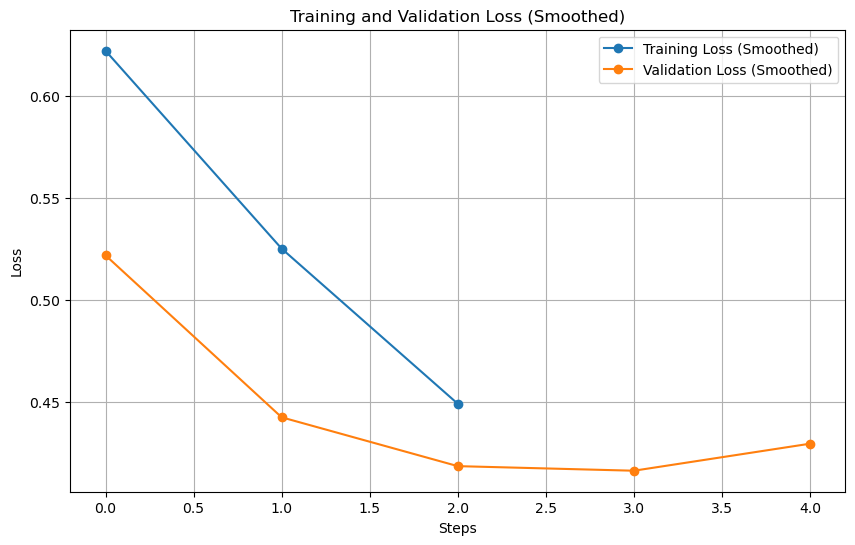

In [46]:
metrics_weak = []

for size, df_train in nested_splits.items():
    print(f"Training with {size} of data...")
    
    # Combine training data with weakly labeled test data
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Tokenize combined training set
    train_ds = convert_and_tokenize(combined_df, tokenizer)

    # Calculate total training steps for callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collect metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics_weak.append(split_metrics)

# Convert metrics to DataFrame
metrics_weak_df = pd.DataFrame(metrics_weak)
metrics_weak_df.to_csv("../data/weak_label_metrics.csv", index=False)

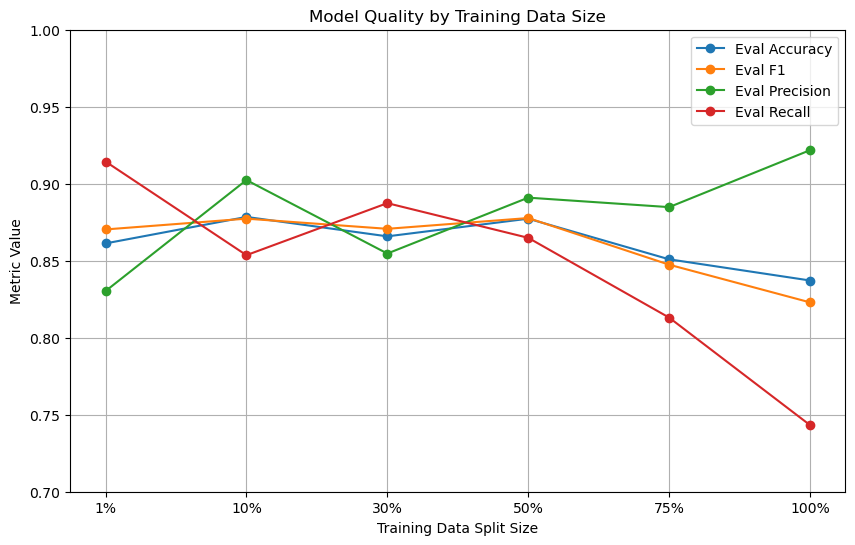

In [47]:
plot_metrics(metrics_weak_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

## Model comparison

This section compares the baseline model performance with the model trained on weakly labeled data. We also evaluate the weak labels directly to determine if they are sufficient for sentiment classification or if training a classification model using these labels is more effective.

1. Compare Baseline and Weak Label Models
2. Evaluate Weak Labels Directly
3. Decide on the Best Approach

In [48]:
# Load metrics
baseline_metrics = pd.read_csv("../data/baseline_metrics.csv")
weak_label_metrics = pd.read_csv("../data/weak_label_metrics.csv")

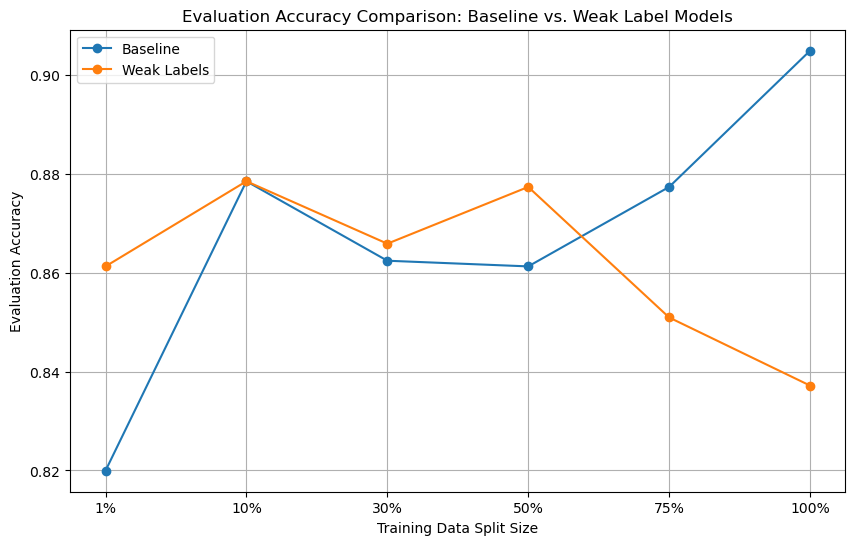

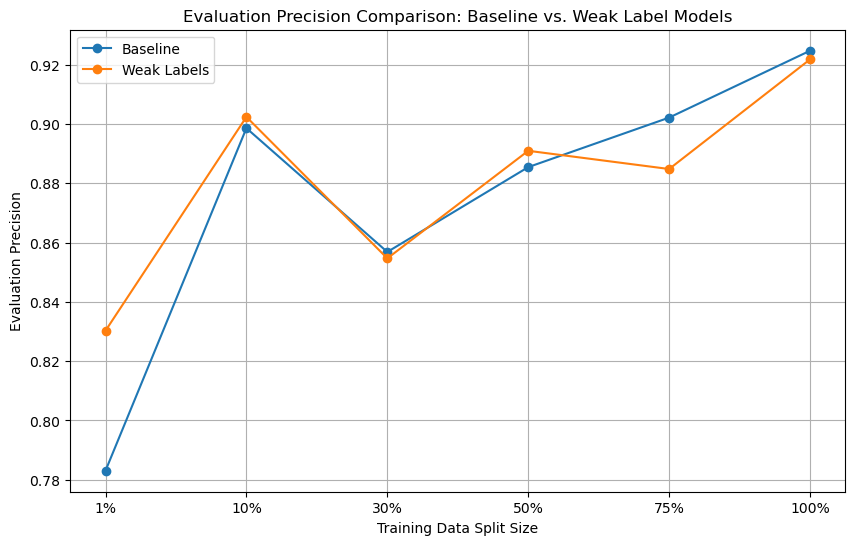

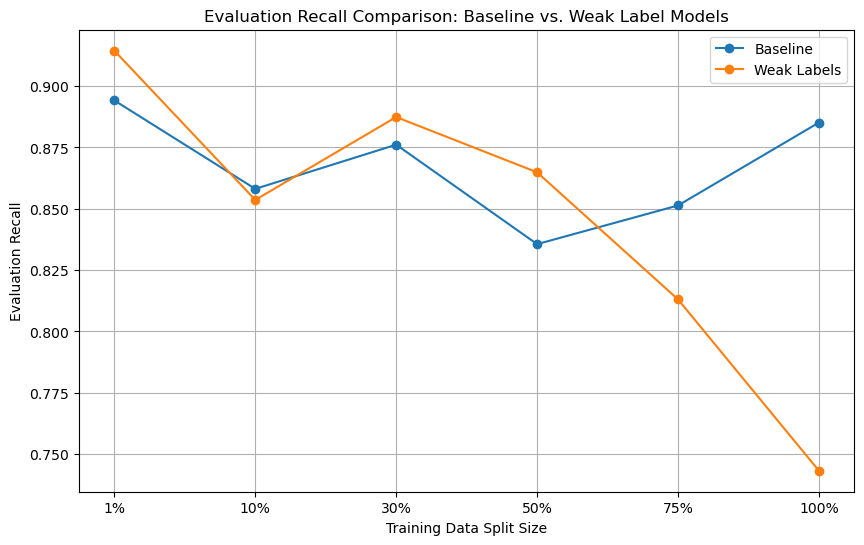

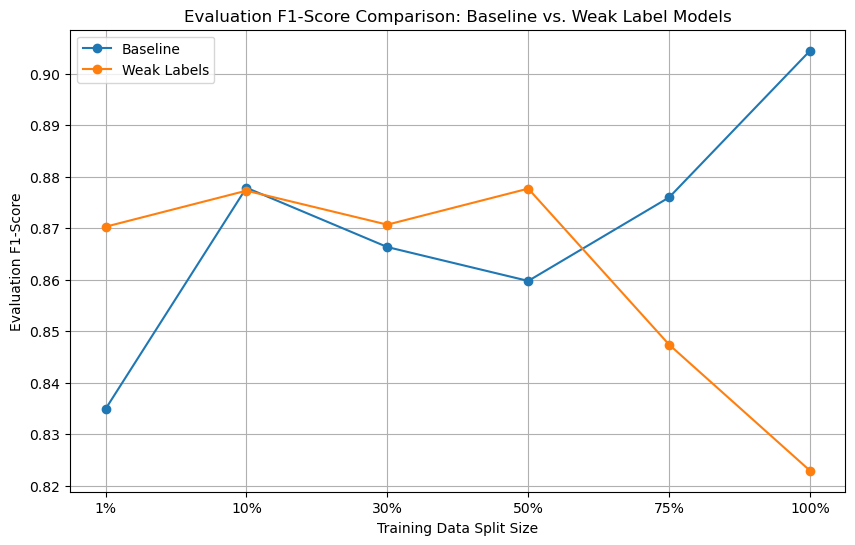

In [49]:
# Plotting function for comparison
def plot_model_comparison(baseline_df, weak_label_df, metric, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(baseline_df["split_size"], baseline_df[metric], label="Baseline", marker="o")
    plt.plot(weak_label_df["split_size"], weak_label_df[metric], label="Weak Labels", marker="o")
    plt.title(f"{ylabel} Comparison: Baseline vs. Weak Label Models")
    plt.xlabel("Training Data Split Size")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot metrics
metrics_to_plot = {
    "eval_accuracy": "Evaluation Accuracy",
    "eval_precision": "Evaluation Precision",
    "eval_recall": "Evaluation Recall",
    "eval_f1": "Evaluation F1-Score",
}

for metric, ylabel in metrics_to_plot.items():
    plot_model_comparison(baseline_metrics, weak_label_metrics, metric, ylabel)

### Decide on the Best Approach

**Observations:**

- Baseline vs. Weak Label Models:
    - The weak label model consistently outperforms the baseline model, especially at larger split sizes (e.g., 100%), with improvements in accuracy and F1 scores.

    - At smaller splits (e.g., 1%), the gap is narrower, highlighting the benefit of weak labels as the dataset grows.

- Weak Labels Directly:
    - Weak labeling strategies, while effective, are not as robust as training a fine-tuned model. The classification model trained on weak labels achieves better results than using weak labels directly, especially in terms of precision and recall.

---

**Conclusion:**

Training a classification model with weak labels is worthwhile as it improves performance significantly over the baseline model. Moreover, weak labels offer a cost-effective alternative to manual annotation, enabling the model to perform well with fewer hard labels. By leveraging weak labels, we estimate a time savings factor of up to 70%, as the need for hard labels diminishes for similar model performance.

---

**Final Decision:**

We recommend using the Weighted Voting weak labeling strategy to generate weak labels and train a classification model for best results.